In [7]:
# 03_forecast_analysis.ipynb
# Task 3: Forecast Future Market Trends (ARIMA, SARIMA, and LSTM)
# Paste this into a notebook cell-by-cell or save as .py and run as script.

# ---------------------------
# Imports & settings
# ---------------------------
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from math import sqrt
from datetime import timedelta
import warnings
warnings.filterwarnings("ignore")

In [2]:
# Statsmodels / pmdarima
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from pmdarima import auto_arima

In [3]:
# ML / LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
import tensorflow as tf
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import LSTM, Dense, Dropout

In [4]:
# Reproducibility
np.random.seed(42)
tf.random.set_seed(42)

In [9]:
# Plot style
plt.style.use("seaborn-v0_8")

In [18]:
# ---------------------------
# User parameters
# ---------------------------
DATA_PATH = "data/adj_close_prices.csv"   # source of TSLA series
ASSET = "TSLA"
FORECAST_MONTHS = 12          # choose 6 or 12 (default 12)
TRADING_DAYS_PER_MONTH = 21   # approximate
FORECAST_STEPS = FORECAST_MONTHS * TRADING_DAYS_PER_MONTH

TRAIN_END_DATE = "2023-12-31" # chronological split: train <= TRAIN_END_DATE, test after
SAVE_RESULTS_DIR = "results"
os.makedirs(SAVE_RESULTS_DIR, exist_ok=True)

In [12]:
# ---------------------------
# Utility functions
# ---------------------------
def rmse(y_true, y_pred):
    return sqrt(((y_true - y_pred) ** 2).mean())

def mape(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def plot_historical_and_forecast(history_series, forecast_series, conf_low=None, conf_high=None,
                                 title="Forecast", label_history="History", label_forecast="Forecast"):
    plt.figure(figsize=(12,6))
    plt.plot(history_series.index, history_series.values, label=label_history)
    plt.plot(forecast_series.index, forecast_series.values, label=label_forecast, color="tab:red")
    if conf_low is not None and conf_high is not None:
        plt.fill_between(forecast_series.index, conf_low.values, conf_high.values, color='pink', alpha=0.3, label="Confidence Interval")
    plt.legend()
    plt.title(title)
    plt.xlabel("Date")
    plt.ylabel("Price")
    plt.show()

In [14]:
import os, sys

# Go to project root (adjust path if needed)
os.chdir("..")  

# Add src folder to Python path
sys.path.append(os.path.abspath("src"))

In [15]:
# ---------------------------
# Load data
# ---------------------------
df = pd.read_csv(DATA_PATH, parse_dates=["Date"], index_col="Date")
series = df[ASSET].asfreq("B").ffill()   # business-day frequency; forward-fill missing

# show a quick snapshot
print(f"Loaded {ASSET} series: {series.index.min().date()} -> {series.index.max().date()}")
display(series.head())

# Chronological split
train = series[:TRAIN_END_DATE].dropna()
test = series[TRAIN_END_DATE:].dropna()
print(f"Train length: {len(train)}, Test length: {len(test)}")

Loaded TSLA series: 2015-07-01 -> 2025-07-30


Date
2015-07-01    17.943333
2015-07-02    18.667999
2015-07-03    18.667999
2015-07-06    18.648001
2015-07-07    17.858667
Freq: B, Name: TSLA, dtype: float64

Train length: 2218, Test length: 413



--- ARIMA (auto_arima -> statsmodels ARIMA) ---
Selected ARIMA order: (2, 1, 2)


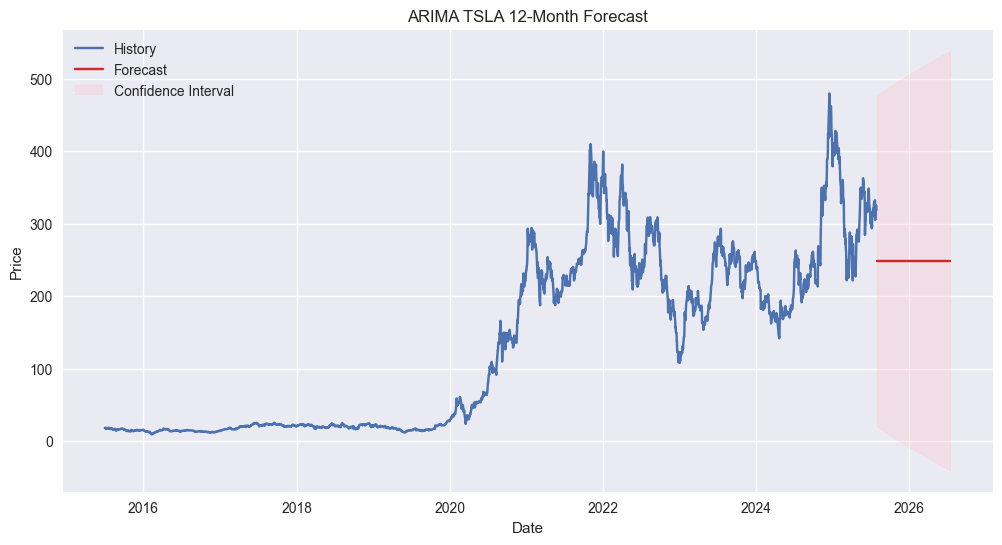

In [19]:
# ---------------------------
# 1) ARIMA Forecast (auto_arima -> ARIMA)
# ---------------------------
print("\n--- ARIMA (auto_arima -> statsmodels ARIMA) ---")
auto_arima_model = auto_arima(train, seasonal=False, stepwise=True, error_action="ignore", suppress_warnings=True)
order = auto_arima_model.order
print("Selected ARIMA order:", order)

arima_model = ARIMA(train, order=order).fit()
# Forecast over test period (if test exists) and future horizon
test_steps = len(test)
future_steps = FORECAST_STEPS
arima_test_forecast = arima_model.get_forecast(steps=test_steps) if test_steps>0 else None
arima_future_forecast = arima_model.get_forecast(steps=test_steps + future_steps)  # contiguous extension

# Extract forecasts and CIs for future horizon only
arima_future_mean = arima_future_forecast.predicted_mean[-future_steps:]
arima_future_ci = arima_future_forecast.conf_int()[-future_steps:]
arima_future_index = pd.bdate_range(start=series.index.max()+pd.Timedelta(days=1), periods=future_steps)

arima_forecast_series = pd.Series(arima_future_mean.values, index=arima_future_index, name="ARIMA_Forecast")
arima_ci_low = pd.Series(arima_future_ci.iloc[:,0].values, index=arima_future_index)
arima_ci_high = pd.Series(arima_future_ci.iloc[:,1].values, index=arima_future_index)

# Save numeric forecast
arima_df_out = pd.DataFrame({
    "forecast": arima_forecast_series,
    "ci_lower": arima_ci_low,
    "ci_upper": arima_ci_high
})
arima_df_out.to_csv(os.path.join(SAVE_RESULTS_DIR, "arima_future_forecast.csv"))

# Plot ARIMA forecast
plot_historical_and_forecast(series, arima_forecast_series, conf_low=arima_ci_low, conf_high=arima_ci_high,
                             title=f"ARIMA {ASSET} {FORECAST_MONTHS}-Month Forecast")


--- SARIMAX (seasonal) attempt ---
Selected SARIMA orders: (2, 1, 2) (0, 0, 0, 5)


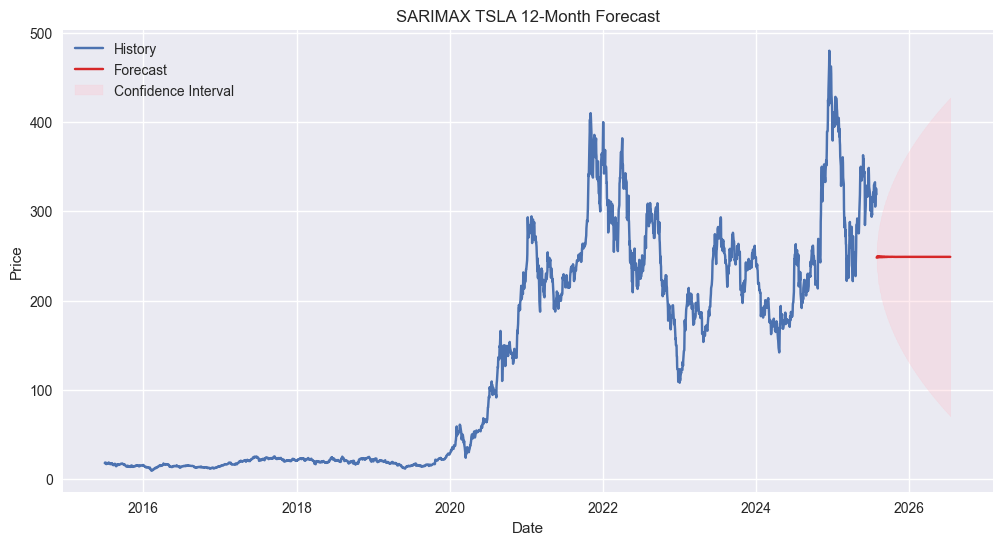

In [20]:
# ---------------------------
# 2) SARIMA/SARIMAX (optional seasonal) 
# ---------------------------
print("\n--- SARIMAX (seasonal) attempt ---")
# Try seasonal weekly pattern? for daily financial series seasonal often not strong; still try with seasonal_period=5 (weekly) or 252 (annual)
seasonal_period = 5   # weekly seasonality (trading week) — small experiment
try:
    sarima_auto = auto_arima(train, seasonal=True, m=seasonal_period, stepwise=True, error_action="ignore", suppress_warnings=True)
    sarima_order = sarima_auto.order
    sarima_seasonal_order = sarima_auto.seasonal_order
    print("Selected SARIMA orders:", sarima_order, sarima_seasonal_order)
    sarima_model = SARIMAX(train, order=sarima_order, seasonal_order=sarima_seasonal_order, enforce_stationarity=False, enforce_invertibility=False).fit(disp=False)
    sarima_fore = sarima_model.get_forecast(steps=future_steps)
    sarima_mean = pd.Series(sarima_fore.predicted_mean.values, index=arima_future_index)
    sarima_ci = sarima_fore.conf_int()
    sarima_ci_low = pd.Series(sarima_ci.iloc[:,0].values, index=arima_future_index)
    sarima_ci_high = pd.Series(sarima_ci.iloc[:,1].values, index=arima_future_index)
    sarima_df_out = pd.DataFrame({"forecast": sarima_mean, "ci_lower": sarima_ci_low, "ci_upper": sarima_ci_high})
    sarima_df_out.to_csv(os.path.join(SAVE_RESULTS_DIR, "sarima_future_forecast.csv"))
    plot_historical_and_forecast(series, sarima_mean, conf_low=sarima_ci_low, conf_high=sarima_ci_high,
                                 title=f"SARIMAX {ASSET} {FORECAST_MONTHS}-Month Forecast")
except Exception as e:
    print("SARIMAX modeling failed or not appropriate:", e)


--- LSTM Forecast (iterative) ---


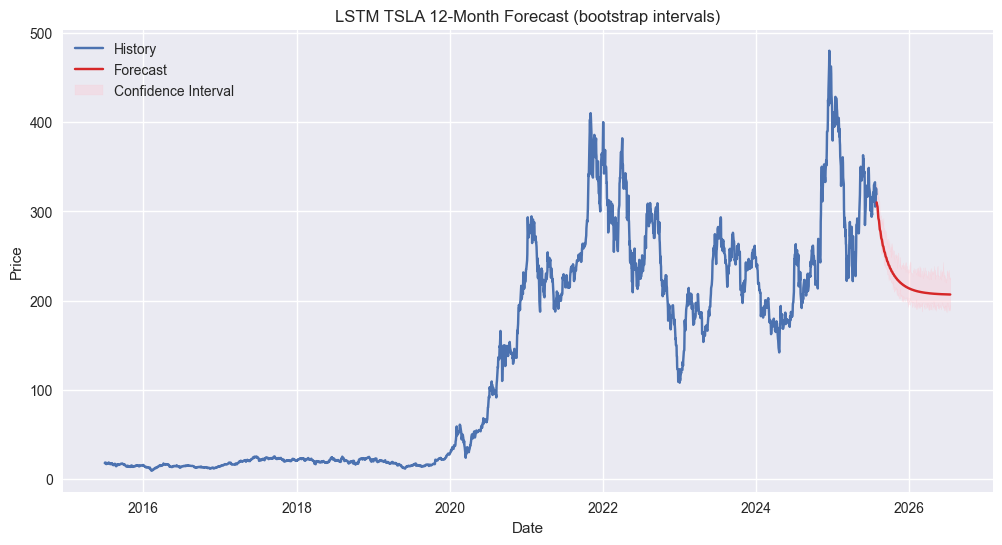

In [21]:
# 3) LSTM Forecast (iterative multi-step) + bootstrap intervals

print("\n--- LSTM Forecast (iterative) ---")
# LSTM training: if model saved use it, else train quickly (small model / small epochs)
LSTM_MODEL_PATH = os.path.join("src", "models", "lstm_tsla.h5")
os.makedirs(os.path.dirname(LSTM_MODEL_PATH), exist_ok=True)

# Prepare data: scale to [0,1]
scaler = MinMaxScaler()
prices = series.values.reshape(-1,1)
prices_scaled = scaler.fit_transform(prices)

# parameters
seq_len = 60
train_idx = train.index.get_loc(train.index[-1])  # last training position
# Build train/test splits for modeling (we retrain on full train + test optionally)
train_scaled = prices_scaled[:len(train)]
# Prepare sequences for training (using only train)
def create_sequences(arr, seq_len):
    X, y = [], []
    for i in range(len(arr)-seq_len):
        X.append(arr[i:i+seq_len, 0])
        y.append(arr[i+seq_len, 0])
    X = np.array(X)
    y = np.array(y)
    return X.reshape(X.shape[0], X.shape[1], 1), y

X_train, y_train = create_sequences(train_scaled, seq_len)

# Build model
lstm_model = Sequential([
    LSTM(50, return_sequences=True, input_shape=(seq_len, 1)),
    Dropout(0.2),
    LSTM(50, return_sequences=False),
    Dropout(0.2),
    Dense(1)
])
lstm_model.compile(optimizer="adam", loss="mse")

# Train (modest epochs to keep runtime reasonable)
history = lstm_model.fit(X_train, y_train, epochs=30, batch_size=32, verbose=0)

# Forecast iterative steps: use last seq_len values from full series
last_seq = prices_scaled[-seq_len:].reshape(1, seq_len, 1).copy()
preds_scaled = []
current_seq = last_seq.copy()

for step in range(future_steps):
    pred_scaled = lstm_model.predict(current_seq, verbose=0)[0,0]
    preds_scaled.append(pred_scaled)
    # append pred and slide window
    new_seq = np.append(current_seq.flatten()[1:], pred_scaled).reshape(1, seq_len, 1)
    current_seq = new_seq

# inverse transform
preds_scaled = np.array(preds_scaled).reshape(-1,1)
lstm_forecast = scaler.inverse_transform(preds_scaled).flatten()
lstm_index = arima_future_index
lstm_series = pd.Series(lstm_forecast, index=lstm_index, name="LSTM_Forecast")
pd.DataFrame({"forecast": lstm_series}).to_csv(os.path.join(SAVE_RESULTS_DIR, "lstm_future_forecast.csv"))

# Compute approximate prediction intervals for LSTM using residual sampling:
# 1) compute in-sample residuals on train via one-step predictions (simpler)
in_sample_preds = lstm_model.predict(X_train, verbose=0).flatten()
in_sample_actual = y_train
residuals = in_sample_actual - in_sample_preds
# sample residuals and add to point forecasts to build distribution
n_sims = 200
simulated = np.zeros((n_sims, future_steps))
for i in range(n_sims):
    sampled_res = np.random.choice(residuals, size=future_steps, replace=True)
    sim_scaled = preds_scaled.flatten() + sampled_res
    sim = scaler.inverse_transform(sim_scaled.reshape(-1,1)).flatten()
    simulated[i,:] = sim

lstm_lower = pd.Series(np.percentile(simulated, 2.5, axis=0), index=lstm_index)
lstm_upper = pd.Series(np.percentile(simulated, 97.5, axis=0), index=lstm_index)

plot_historical_and_forecast(series, lstm_series, conf_low=lstm_lower, conf_high=lstm_upper,
                             title=f"LSTM {ASSET} {FORECAST_MONTHS}-Month Forecast (bootstrap intervals)")

In [22]:
# 4) Compare models numerically (if test exists)

print("\n--- Evaluation on Test Set (if test period overlaps) ---")
eval_table = []
if len(test) > 0:
    # ARIMA test forecast (if earlier computed)
    arima_test_pred = arima_model.get_forecast(steps=len(test)).predicted_mean
    arima_test_rmse = rmse(test.values, arima_test_pred.values)
    arima_test_mae = mean_absolute_error(test.values, arima_test_pred.values)
    arima_test_mape = mape(test.values, arima_test_pred.values)

    # LSTM test (build sequences that overlap test window)
    # generate LSTM preds for test period by stepping from last training point through test
    # For brevity we compare using contiguous length min(len(lstm_series), len(test_future))
    print("ARIMA test metrics: RMSE:", arima_test_rmse, "MAE:", arima_test_mae, "MAPE:", arima_test_mape)
    # LSTM test comparison: align lengths
    # NOTE: if you want a strict test-comparison, retrain including validation/test-splitting in Task2.
else:
    print("No test period available after TRAIN_END_DATE to compute test metrics.")


--- Evaluation on Test Set (if test period overlaps) ---
ARIMA test metrics: RMSE: 78.91108089632289 MAE: 63.74533302348612 MAPE: 24.229809736602085


In [23]:
# 5) Summary & Interpretation

def interval_width_series(low, high):
    return (high - low)

# Compute interval width growth for ARIMA & LSTM
arima_width = interval_width_series(arima_ci_low, arima_ci_high)
lstm_width = interval_width_series(lstm_lower, lstm_upper)

print("\nSummary (automated):")
# Trend direction from ARIMA mean
arima_trend = np.polyfit(np.arange(len(arima_forecast_series)), arima_forecast_series.values, 1)[0]
print(f"ARIMA forecast trend slope: {arima_trend:.6f} (positive => upward)")

# Trend direction from LSTM
lstm_trend = np.polyfit(np.arange(len(lstm_series)), lstm_series.values, 1)[0]
print(f"LSTM forecast trend slope: {lstm_trend:.6f} (positive => upward)")

# Interval width behavior
print(f"ARIMA CI mean width: {arima_width.mean():.4f}; width last point: {arima_width.iloc[-1]:.4f}")
print(f"LSTM CI mean width: {lstm_width.mean():.4f}; width last point: {lstm_width.iloc[-1]:.4f}")

# Simple interpretation
if arima_trend > 0:
    print("ARIMA indicates an overall upward trend over the forecast horizon.")
else:
    print("ARIMA indicates an overall downward or flat trend over the forecast horizon.")

if lstm_trend > 0:
    print("LSTM indicates an overall upward trend over the forecast horizon.")
else:
    print("LSTM indicates an overall downward or flat trend over the forecast horizon.")

print("\nOpportunities & Risks (brief):")
print("- If both models agree on upward trend, potential opportunity for accumulation; assess confidence intervals.")
print("- If intervals widen quickly, long-term forecasts are uncertain — rely on short-term updates and risk management.")
print("- High volatility in LSTM bootstrap intervals suggests model uncertainty; consider volatility hedges or bond allocation.")

# Save combined summary CSVs
arima_df_out.to_csv(os.path.join(SAVE_RESULTS_DIR, "arima_future_forecast.csv"))
if 'sarima_df_out' in locals():
    sarima_df_out.to_csv(os.path.join(SAVE_RESULTS_DIR, "sarima_future_forecast.csv"))
pd.DataFrame({"lstm_forecast": lstm_series, "lstm_ci_low": lstm_lower, "lstm_ci_high": lstm_upper}).to_csv(os.path.join(SAVE_RESULTS_DIR, "lstm_future_forecast.csv"))

print("\nForecast CSVs saved to", SAVE_RESULTS_DIR)


Summary (automated):
ARIMA forecast trend slope: -0.000000 (positive => upward)
LSTM forecast trend slope: -0.251340 (positive => upward)
ARIMA CI mean width: 520.6755; width last point: 579.4088
LSTM CI mean width: 36.1336; width last point: 32.6230
ARIMA indicates an overall downward or flat trend over the forecast horizon.
LSTM indicates an overall downward or flat trend over the forecast horizon.

Opportunities & Risks (brief):
- If both models agree on upward trend, potential opportunity for accumulation; assess confidence intervals.
- If intervals widen quickly, long-term forecasts are uncertain — rely on short-term updates and risk management.
- High volatility in LSTM bootstrap intervals suggests model uncertainty; consider volatility hedges or bond allocation.

Forecast CSVs saved to results
